In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from scipy import interpolate
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from scipy import stats
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from scipy.linalg import norm
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
import statsmodels.api as sm
from pandas import DataFrame
%matplotlib inline

In [13]:
# Loading data
path = 'raw/AMZN_stock_market_data.csv'
price_data = pd.read_csv(path, parse_dates = ['Date'])

In [14]:
price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1274,2019-01-25,1670.500000,1683.479980,1661.609985,1670.569946,1670.569946,4945900
1275,2019-01-28,1643.589966,1645.000000,1614.089966,1637.890015,1637.890015,4837700
1276,2019-01-29,1631.270020,1632.380005,1590.719971,1593.880005,1593.880005,4632800
1277,2019-01-30,1623.000000,1676.949951,1619.680054,1670.430054,1670.430054,5783800
1278,2019-01-31,1692.849976,1736.410034,1679.079956,1718.729980,1718.729980,10910300


Text(0, 0.5, 'Stock price')

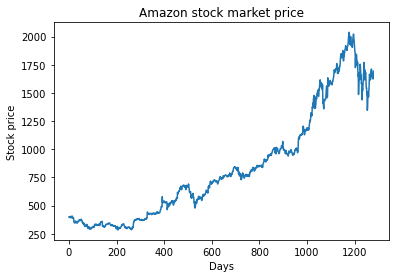

In [6]:
# Plotting open Amazon stock prices 
plt.plot(price_data.loc[0:len(price_data),'Open'])
plt.title('Amazon stock market price')
plt.xlabel('Days')
plt.ylabel('Stock price') 


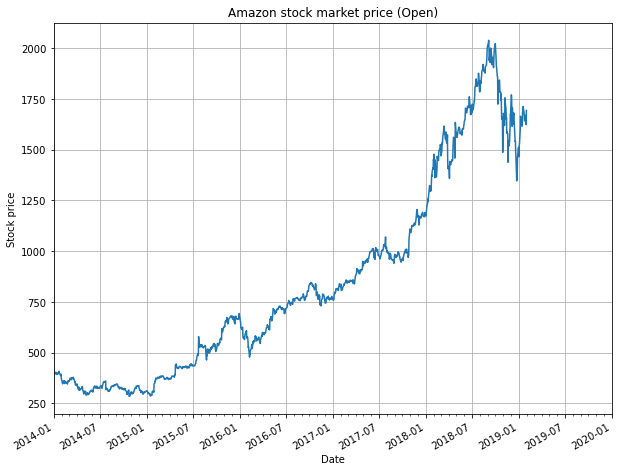

In [25]:
# Plotting open Amazon stock prices 
fig, ax = plt.subplots(figsize = (10,8))
ax.plot('Date', 'Open', data=price_data)

# Major ticks every 6 months.
fmt_half_year = mdates.MonthLocator(interval=6)
ax.xaxis.set_major_locator(fmt_half_year)

# Minor ticks every month.
fmt_month = mdates.MonthLocator()
ax.xaxis.set_minor_locator(fmt_month)

# Text in the x axis will be displayed in 'YYYY-mm' format.
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Round to nearest years.
datemin = np.datetime64(price_data.Date.iloc[0], 'Y')
datemax = np.datetime64(price_data.Date.iloc[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

# Format the coords message box, i.e. the numbers displayed as the cursor moves
# across the axes within the interactive GUI.
ax.format_xdata = mdates.DateFormatter('%Y-%m')
ax.format_ydata = lambda x: f'${x:.2f}'  # Format the price.
ax.grid(True)

# Rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them.
fig.autofmt_xdate()

plt.title('Amazon stock market price (Open)')
plt.xlabel('Date')
plt.ylabel('Stock price') 

plt.show()


In [45]:
mad_open = price_data.Open.mad()
median_open= price_data.Open.median()

mad = lambda x: np.fabs(x - x.mean()).mean()
price_data['Open_Rolling_mad']=price_data['Open'].rolling(window=60, center=True).apply(mad)
#60-day standard deviation 
price_data['Open_Rolling_Med']=price_data['Open'].rolling(window=60, center=True).median()
#Detect anomalies by determining how far away from the mean (in terms of standard deviation)
#each data point is
price_data['Open_LP_Anomaly']=(abs(price_data.Open - price_data.Open_Rolling_Med)/ price_data.Open_Rolling_mad)>3


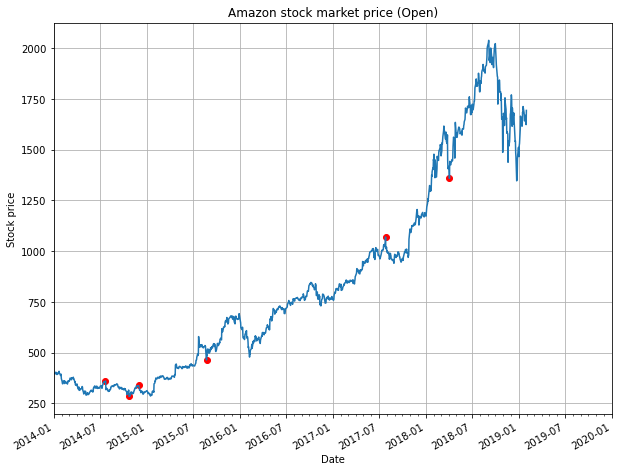

In [47]:
# Plotting open Amazon stock prices with outliers
fig, ax = plt.subplots(figsize = (10,8))
ax.plot('Date', 'Open', data=price_data)

# Major ticks every 6 months.
fmt_half_year = mdates.MonthLocator(interval=6)
ax.xaxis.set_major_locator(fmt_half_year)

# Minor ticks every month.
fmt_month = mdates.MonthLocator()
ax.xaxis.set_minor_locator(fmt_month)

# Text in the x axis will be displayed in 'YYYY-mm' format.
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Round to nearest years.
datemin = np.datetime64(price_data.Date.iloc[0], 'Y')
datemax = np.datetime64(price_data.Date.iloc[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

# Format the coords message box, i.e. the numbers displayed as the cursor moves
# across the axes within the interactive GUI.
ax.format_xdata = mdates.DateFormatter('%Y-%m')
ax.format_ydata = lambda x: f'${x:.2f}'  # Format the price.
ax.grid(True)

# Rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them.
fig.autofmt_xdate()

plt.scatter(price_data.Date[price_data['Open_LP_Anomaly']], price_data.Open[price_data['Open_LP_Anomaly']],color='red')

ax.legend(['Open price', ''])
plt.title('Amazon stock market price (Open)')
plt.xlabel('Date')
plt.ylabel('Stock price') 

plt.show()


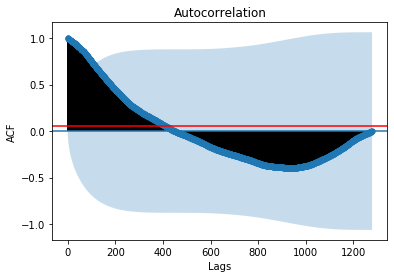

In [5]:
# Plotting autocorrelation function of time-series data
Open_prices=price_data['Open']

# Computing critical threshold
thres_ACF=2/np.sqrt(len(Open_prices))

# Plotting autocorrelation function
lags_list=[x for x in range(0,len(Open_prices))]
plot_acf(Open_prices, lags=lags_list)
plt.axhline(y=thres_ACF, color='r', linestyle='-')
plt.xlabel('Lags')
plt.ylabel('ACF') 
plt.show()

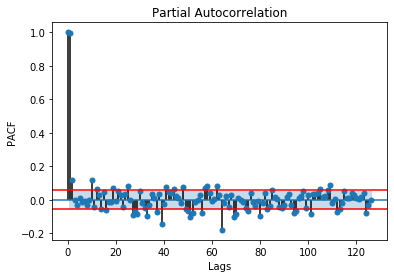

In [56]:
# Plotting partial autocorrelation function of time-series data
Open_prices=price_data['Open']

# Computing critical threshold
thres_ACF=2/np.sqrt(len(Open_prices))
n=int(len(Open_prices)/10)  # number of lags

# Loading stock prices
Open_prices=price_data['Open']
lags_list=[x for x in range(0,n)]
plot_pacf(Open_prices, lags=lags_list)
plt.axhline(y=thres_ACF, color='r', linestyle='-')
plt.axhline(y=-thres_ACF, color='r', linestyle='-')
plt.xlabel('Lags')
plt.ylabel('PACF') 
plt.show()


                               SARIMAX Results                                
Dep. Variable:                   Open   No. Observations:                 1022
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -3910.809
Date:                Thu, 01 Apr 2021   AIC                           7831.618
Time:                        07:16:34   BIC                           7856.261
Sample:                             0   HQIC                          7840.975
                               - 1022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2272      0.044     -5.137      0.000      -0.314      -0.141
ar.L2         -0.8995      0.051    -17.622      0.000      -1.000      -0.799
ma.L1          0.2227      0.038      5.831      0.0

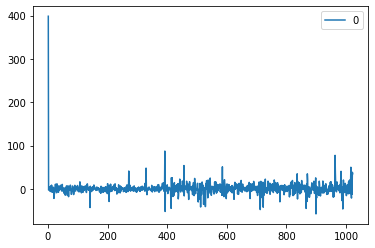

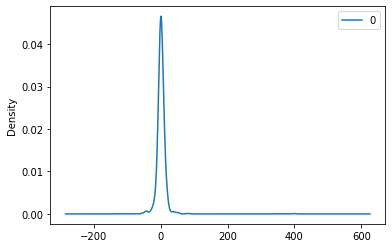

                 0
count  1022.000000
mean      1.329737
std      16.670694
min     -57.330743
25%      -3.950619
50%       0.792221
75%       5.987614
max     398.290009


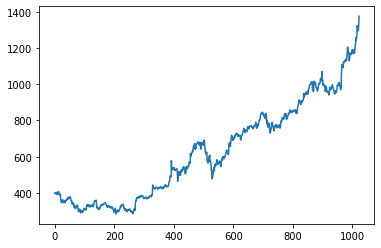

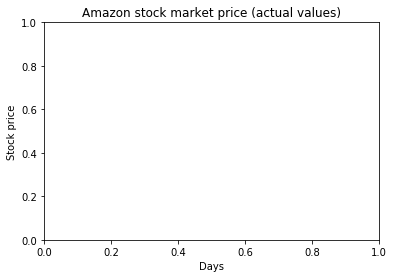

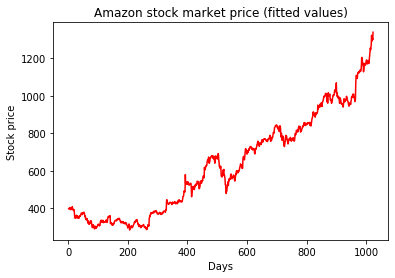

ARIMA: predicted=1373.760667, expected=1368.000000
Holts Winters: predicted=1373.921130, expected=1368.000000


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


ARIMA: predicted=1368.286715, expected=1392.010010
Holts Winters: predicted=1368.149711, expected=1392.010010
ARIMA: predicted=1392.603924, expected=1409.180054
Holts Winters: predicted=1391.379295, expected=1409.180054


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA: predicted=1409.548369, expected=1403.170044
Holts Winters: predicted=1408.767032, expected=1403.170044
ARIMA: predicted=1403.227449, expected=1451.300049
Holts Winters: predicted=1403.304368, expected=1451.300049
ARIMA: predicted=1450.434223, expected=1445.000000
Holts Winters: predicted=1450.058749, expected=1445.000000
ARIMA: predicted=1447.114164, expected=1477.390015
Holts Winters: predicted=1445.137373, expected=1477.390015
ARIMA: predicted=1477.218103, expected=1402.619995
Holts Winters: predicted=1476.472767, expected=1402.619995
ARIMA: predicted=1402.950612, expected=1361.459961
Holts Winters: predicted=1405.919157, expected=1361.459961
ARIMA: predicted=1358.413416, expected=1449.000000
Holts Winters: predicted=1362.449776, expected=1449.000000


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA: predicted=1444.751208, expected=1429.680054
Holts Winters: predicted=1444.612033, expected=1429.680054


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA: predicted=1433.705669, expected=1373.489990
Holts Winters: predicted=1430.533984, expected=1373.489990
ARIMA: predicted=1376.558098, expected=1364.670044
Holts Winters: predicted=1376.688036, expected=1364.670044
ARIMA: predicted=1366.588546, expected=1385.930054
Holts Winters: predicted=1365.270009, expected=1385.930054
ARIMA: predicted=1385.166414, expected=1406.250000
Holts Winters: predicted=1384.829658, expected=1406.250000
ARIMA: predicted=1404.418258, expected=1466.890015
Holts Winters: predicted=1405.176905, expected=1466.890015
ARIMA: predicted=1463.717027, expected=1457.369995
Holts Winters: predicted=1464.409292, expected=1457.369995
ARIMA: predicted=1454.801930, expected=1446.489990
Holts Winters: predicted=1457.667268, expected=1446.489990
ARIMA: predicted=1447.231584, expected=1485.000000
Holts Winters: predicted=1446.971529, expected=1485.000000
ARIMA: predicted=1483.060667, expected=1495.359985
Holts Winters: predicted=1483.247048, expected=1495.359985
ARIMA: pre

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA: predicted=1569.252235, expected=1539.010010
Holts Winters: predicted=1566.215324, expected=1539.010010
ARIMA: predicted=1542.036333, expected=1530.000000
Holts Winters: predicted=1539.950685, expected=1530.000000
ARIMA: predicted=1531.034173, expected=1572.400024
Holts Winters: predicted=1530.324760, expected=1572.400024
ARIMA: predicted=1571.601069, expected=1447.000000
Holts Winters: predicted=1570.891010, expected=1447.000000
ARIMA: predicted=1452.329123, expected=1406.000000
Holts Winters: predicted=1455.513337, expected=1406.000000
ARIMA: predicted=1416.939406, expected=1417.619995
Holts Winters: predicted=1407.509053, expected=1417.619995
ARIMA: predicted=1416.104750, expected=1391.380005
Holts Winters: predicted=1417.256716, expected=1391.380005
ARIMA: predicted=1392.211200, expected=1358.239990
Holts Winters: predicted=1392.356194, expected=1358.239990
ARIMA: predicted=1362.772075, expected=1441.989990
Holts Winters: predicted=1359.344365, expected=1441.989990
ARIMA: pre

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA: predicted=1703.042110, expected=1696.000000
Holts Winters: predicted=1706.537702, expected=1696.000000
ARIMA: predicted=1698.966684, expected=1724.050049
Holts Winters: predicted=1696.768908, expected=1724.050049
ARIMA: predicted=1723.101903, expected=1738.530029
Holts Winters: predicted=1722.017266, expected=1738.530029
ARIMA: predicted=1733.681446, expected=1737.989990
Holts Winters: predicted=1737.338096, expected=1737.989990
ARIMA: predicted=1739.357050, expected=1764.510010
Holts Winters: predicted=1737.942888, expected=1764.510010
ARIMA: predicted=1764.427874, expected=1803.930054
Holts Winters: predicted=1762.594116, expected=1803.930054
ARIMA: predicted=1795.550992, expected=1821.949951
Holts Winters: predicted=1801.179658, expected=1821.949951
ARIMA: predicted=1824.175473, expected=1811.560059
Holts Winters: predicted=1820.663414, expected=1811.560059
ARIMA: predicted=1813.741881, expected=1848.000000
Holts Winters: predicted=1812.136702, expected=1848.000000


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA: predicted=1840.584531, expected=1829.459961
Holts Winters: predicted=1845.676545, expected=1829.459961


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA: predicted=1827.672134, expected=1825.010010
Holts Winters: predicted=1830.548261, expected=1825.010010


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA: predicted=1833.972077, expected=1812.209961
Holts Winters: predicted=1825.381571, expected=1812.209961


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA: predicted=1808.923762, expected=1829.010010
Holts Winters: predicted=1813.088998, expected=1829.010010


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA: predicted=1822.124028, expected=1829.300049
Holts Winters: predicted=1827.931997, expected=1829.300049


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA: predicted=1836.530479, expected=1839.000000
Holts Winters: predicted=1829.207568, expected=1839.000000
ARIMA: predicted=1840.690649, expected=1876.050049
Holts Winters: predicted=1838.338414, expected=1876.050049


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA: predicted=1866.642102, expected=1827.329956
Holts Winters: predicted=1873.569683, expected=1827.329956


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA: predicted=1832.648508, expected=1786.489990
Holts Winters: predicted=1830.731863, expected=1786.489990
ARIMA: predicted=1794.467080, expected=1784.000000
Holts Winters: predicted=1789.345515, expected=1784.000000


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA: predicted=1776.148913, expected=1788.770020
Holts Winters: predicted=1784.338382, expected=1788.770020
ARIMA: predicted=1786.823049, expected=1837.739990
Holts Winters: predicted=1788.485940, expected=1837.739990
ARIMA: predicted=1846.305124, expected=1825.810059
Holts Winters: predicted=1834.626296, expected=1825.810059
ARIMA: predicted=1821.415155, expected=1854.530029
Holts Winters: predicted=1826.378753, expected=1854.530029
ARIMA: predicted=1848.093383, expected=1861.000000
Holts Winters: predicted=1852.673564, expected=1861.000000
ARIMA: predicted=1868.338244, expected=1882.000000
Holts Winters: predicted=1860.461520, expected=1882.000000
ARIMA: predicted=1882.783185, expected=1888.510010
Holts Winters: predicted=1880.624082, expected=1888.510010
ARIMA: predicted=1880.248149, expected=1898.500000
Holts Winters: predicted=1888.013376, expected=1898.500000
ARIMA: predicted=1902.562827, expected=1919.390015
Holts Winters: predicted=1897.842956, expected=1919.390015
ARIMA: pre

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA: predicted=1904.423877, expected=1885.800049
Holts Winters: predicted=1904.322163, expected=1885.800049
ARIMA: predicted=1892.960352, expected=1890.569946
Holts Winters: predicted=1886.942833, expected=1890.569946


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA: predicted=1885.794005, expected=1880.000000
Holts Winters: predicted=1890.345358, expected=1880.000000
ARIMA: predicted=1876.299795, expected=1876.640015
Holts Winters: predicted=1880.642782, expected=1876.640015
ARIMA: predicted=1883.908526, expected=1907.170044
Holts Winters: predicted=1876.887872, expected=1907.170044


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA: predicted=1905.347165, expected=1910.510010
Holts Winters: predicted=1905.275175, expected=1910.510010
ARIMA: predicted=1903.968612, expected=1915.000000
Holts Winters: predicted=1910.187398, expected=1915.000000
ARIMA: predicted=1920.800258, expected=1937.729980
Holts Winters: predicted=1914.703016, expected=1937.729980


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA: predicted=1939.667372, expected=1953.449951
Holts Winters: predicted=1936.321278, expected=1953.449951


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA: predicted=1945.749409, expected=1997.420044
Holts Winters: predicted=1952.434970, expected=1997.420044
ARIMA: predicted=1998.978635, expected=2007.000000
Holts Winters: predicted=1994.916898, expected=2007.000000


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA: predicted=2012.436679, expected=2026.500000
Holts Winters: predicted=2006.361948, expected=2026.500000


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA: predicted=2020.797376, expected=2038.109985
Holts Winters: predicted=2025.453023, expected=2038.109985


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA: predicted=2035.744904, expected=2006.510010
Holts Winters: predicted=2037.467031, expected=2006.510010
ARIMA: predicted=2014.249634, expected=1938.709961
Holts Winters: predicted=2008.141267, expected=1938.709961
ARIMA: predicted=1938.526572, expected=1971.000000
Holts Winters: predicted=1941.721312, expected=1971.000000


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA: predicted=1964.267823, expected=1928.270020
Holts Winters: predicted=1969.497031, expected=1928.270020
ARIMA: predicted=1933.465021, expected=1994.000000
Holts Winters: predicted=1930.604131, expected=1994.000000
ARIMA: predicted=1996.247226, expected=2000.000000
Holts Winters: predicted=1989.775047, expected=2000.000000
ARIMA: predicted=1991.858463, expected=1992.930054
Holts Winters: predicted=1999.349345, expected=1992.930054
ARIMA: predicted=1995.992116, expected=1954.729980
Holts Winters: predicted=1993.346641, expected=1954.729980
ARIMA: predicted=1962.162313, expected=1918.650024
Holts Winters: predicted=1957.204386, expected=1918.650024
ARIMA: predicted=1913.002266, expected=1940.500000
Holts Winters: predicted=1920.872556, expected=1940.500000
ARIMA: predicted=1937.292200, expected=1938.579956
Holts Winters: predicted=1939.306305, expected=1938.579956
ARIMA: predicted=1945.721391, expected=1954.219971
Holts Winters: predicted=1938.624413, expected=1954.219971
ARIMA: pre

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA: predicted=1857.043526, expected=1724.000000
Holts Winters: predicted=1858.019485, expected=1724.000000
ARIMA: predicted=1724.937247, expected=1808.000000
Holts Winters: predicted=1729.877917, expected=1808.000000
ARIMA: predicted=1809.638503, expected=1795.000000
Holts Winters: predicted=1802.151127, expected=1795.000000
ARIMA: predicted=1790.529059, expected=1783.500000
Holts Winters: predicted=1795.573758, expected=1783.500000
ARIMA: predicted=1785.999348, expected=1842.790039
Holts Winters: predicted=1784.480401, expected=1842.790039
ARIMA: predicted=1843.219590, expected=1821.489990
Holts Winters: predicted=1837.919236, expected=1821.489990
ARIMA: predicted=1816.481659, expected=1785.160034
Holts Winters: predicted=1822.898403, expected=1785.160034
ARIMA: predicted=1790.944566, expected=1784.000000
Holts Winters: predicted=1788.375502, expected=1784.000000
ARIMA: predicted=1786.934965, expected=1742.239990
Holts Winters: predicted=1784.368687, expected=1742.239990
ARIMA: pre

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA: predicted=1708.323938, expected=1649.589966
Holts Winters: predicted=1709.625315, expected=1649.589966
ARIMA: predicted=1659.730328, expected=1660.000000
Holts Winters: predicted=1654.340873, expected=1660.000000
ARIMA: predicted=1656.978393, expected=1486.160034
Holts Winters: predicted=1659.545493, expected=1486.160034
ARIMA: predicted=1488.219377, expected=1569.989990
Holts Winters: predicted=1500.298387, expected=1569.989990
ARIMA: predicted=1572.513430, expected=1623.530029
Holts Winters: predicted=1562.706827, expected=1623.530029


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA: predicted=1602.732449, expected=1678.589966
Holts Winters: predicted=1617.111432, expected=1678.589966


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA: predicted=1691.858332, expected=1657.569946
Holts Winters: predicted=1672.806525, expected=1657.569946
ARIMA: predicted=1655.139731, expected=1618.349976
Holts Winters: predicted=1659.044033, expected=1618.349976
ARIMA: predicted=1624.995304, expected=1673.000000
Holts Winters: predicted=1622.296149, expected=1673.000000
ARIMA: predicted=1663.365414, expected=1755.000000
Holts Winters: predicted=1667.814826, expected=1755.000000


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA: predicted=1743.346718, expected=1732.500000
Holts Winters: predicted=1747.065557, expected=1732.500000


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA: predicted=1740.071575, expected=1698.239990
Holts Winters: predicted=1733.854892, expected=1698.239990


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA: predicted=1702.894283, expected=1649.290039
Holts Winters: predicted=1701.609866, expected=1649.290039
ARIMA: predicted=1648.664157, expected=1656.319946
Holts Winters: predicted=1653.949001, expected=1656.319946
ARIMA: predicted=1661.861433, expected=1581.010010
Holts Winters: predicted=1656.108987, expected=1581.010010
ARIMA: predicted=1580.037690, expected=1587.500000
Holts Winters: predicted=1587.709057, expected=1587.500000
ARIMA: predicted=1595.047151, expected=1577.010010
Holts Winters: predicted=1587.518359, expected=1577.010010
ARIMA: predicted=1565.959783, expected=1437.500000
Holts Winters: predicted=1577.944824, expected=1437.500000
ARIMA: predicted=1454.751616, expected=1542.989990
Holts Winters: predicted=1449.416752, expected=1542.989990
ARIMA: predicted=1529.542831, expected=1517.000000
Holts Winters: predicted=1532.531993, expected=1517.000000
ARIMA: predicted=1512.286357, expected=1539.000000
Holts Winters: predicted=1518.844773, expected=1539.000000
ARIMA: pre

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA: predicted=1424.013724, expected=1473.349976
Holts Winters: predicted=1443.720990, expected=1473.349976
ARIMA: predicted=1508.905637, expected=1510.800049
Holts Winters: predicted=1469.940661, expected=1510.800049
ARIMA: predicted=1478.180891, expected=1465.199951
Holts Winters: predicted=1506.167966, expected=1465.199951
ARIMA: predicted=1483.627024, expected=1520.010010
Holts Winters: predicted=1469.980788, expected=1520.010010
ARIMA: predicted=1512.075667, expected=1530.000000
Holts Winters: predicted=1513.999770, expected=1530.000000


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA: predicted=1511.958519, expected=1602.310059
Holts Winters: predicted=1528.102137, expected=1602.310059


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA: predicted=1624.543885, expected=1664.689941
Holts Winters: predicted=1593.695023, expected=1664.689941
ARIMA: predicted=1657.345960, expected=1652.979980
Holts Winters: predicted=1657.212961, expected=1652.979980
ARIMA: predicted=1654.761148, expected=1641.010010
Holts Winters: predicted=1653.428058, expected=1641.010010


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA: predicted=1627.255505, expected=1640.550049
Holts Winters: predicted=1642.340159, expected=1640.550049


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA: predicted=1631.209003, expected=1615.000000
Holts Winters: predicted=1640.741683, expected=1615.000000
ARIMA: predicted=1643.780388, expected=1632.000000
Holts Winters: predicted=1617.752718, expected=1632.000000
ARIMA: predicted=1601.998714, expected=1684.219971
Holts Winters: predicted=1630.468838, expected=1684.219971


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA: predicted=1700.250889, expected=1680.000000
Holts Winters: predicted=1678.496847, expected=1680.000000
ARIMA: predicted=1679.375656, expected=1712.000000
Holts Winters: predicted=1679.840998, expected=1712.000000
ARIMA: predicted=1686.620176, expected=1681.000000
Holts Winters: predicted=1708.593601, expected=1681.000000
ARIMA: predicted=1706.721220, expected=1656.000000
Holts Winters: predicted=1683.961798, expected=1656.000000
ARIMA: predicted=1639.670417, expected=1641.069946
Holts Winters: predicted=1658.970742, expected=1641.069946
ARIMA: predicted=1648.938018, expected=1670.500000
Holts Winters: predicted=1642.953312, expected=1670.500000
ARIMA: predicted=1670.837095, expected=1643.589966
Holts Winters: predicted=1667.570903, expected=1643.589966
ARIMA: predicted=1637.129986, expected=1631.270020
Holts Winters: predicted=1646.164722, expected=1631.270020
ARIMA: predicted=1646.311924, expected=1623.000000
Holts Winters: predicted=1632.861413, expected=1623.000000
ARIMA: pre

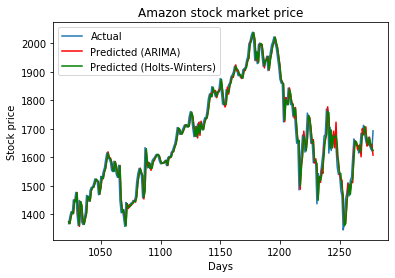

In [68]:
# ARIMA forecasting model - next day's stock market price prediction

# Based on the ACF and PACF we define our model as:

q=2   #MA model order
p=2   #AR model order

# Train-test data split
n_train=int(0.80*len(Open_prices))
n_end=len(Open_prices)+1
Open_prices_train=Open_prices.iloc[1:n_train]
Open_prices_test=Open_prices.iloc[n_train:n_end]



# ARIMA - model fit
#fit model
model = ARIMA(Open_prices_train, order=(p,1,q))
model_fit = model.fit()

# summary of fit model
print(model_fit.summary())

# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
plt.show()

# density plot of residuals
residuals.plot(kind='kde')
plt.show()

# summary stats of residuals
print(residuals.describe())


#Model fit check

#plotting open Amazon stock prices from train data 
plt.plot(price_data.loc[0:len(Open_prices_train),'Open'])
plt.show()
plt.title('Amazon stock market price (actual values)')
plt.xlabel('Days')
plt.ylabel('Stock price') 
plt.show()

#plotting ARIMA fitted values
plt.plot(model_fit.fittedvalues[1:len(Open_prices_train)], color='red')
plt.title('Amazon stock market price (fitted values)')
plt.xlabel('Days')
plt.ylabel('Stock price') 
plt.show()


# Forecasting using the ARIMA model

# ARIMA vs Holts-Winters model performance - predicting next day's stock prices

history = [x for x in Open_prices_train]
history_holts = [x for x in Open_prices_train]
predictions = list()
predictions_holts=list()

# Rolling forecasting using ARIMA and Holts-Winters (next day's prices)
for t in range(n_train,len(Open_prices)):
    
    #ARIMA Model
    model = ARIMA(history, order=(p,1,q))   
    model_fit = model.fit()                
    output = model_fit.forecast()           
    yhat = output[0]
    predictions.append(yhat)
    obs = Open_prices_test[t]
    history.append(obs)
    print('ARIMA: predicted=%f, expected=%f' % (yhat, obs))
    
    # Holts-Winters Triple Exponential Smoothing
    #model_holts = ExponentialSmoothing(history_holts, trend="add", seasonal="add",  seasonal_periods=260).fit()  #Holts winters model
   
    # Holts-Winters Simple Exponential Smoothing Model
    model_holts = SimpleExpSmoothing(history_holts).fit()  #Holts winters model
    output_holts = model_holts.forecast() 
    yhat_holts = output_holts[0]
    predictions_holts.append(yhat_holts)
    history_holts.append(obs) 
    print('Holts Winters: predicted=%f, expected=%f' % (yhat_holts, obs))
    
    
#Computing sign accuracy of ARIMA and Holts-Winters models
i=1
returns_num_ARIMA=0
returns_num_Holts=0
returns_tot=0
while i<=len(predictions)-1:
    returns_predictions_ARIMA=predictions[i]-predictions[i-1]
    returns_predictions_holts=predictions_holts[i]-predictions_holts[i-1]
    index_next=len(Open_prices)-len(predictions)+i
    index_previous=len(Open_prices)-len(predictions)+i-1
    returns_actual=Open_prices_test[index_next]-Open_prices_test[index_previous]
    if np.sign(returns_predictions_ARIMA)==np.sign(returns_actual):
        returns_num_ARIMA+=1
    if np.sign(returns_predictions_Holts)==np.sign(returns_actual):
        returns_num_Holts+=1
    returns_tot+=1
    i+=1
        
print('Sign accuracy (ARIMA) for next day prices:', returns_num_ARIMA/returns_tot)
print('Sign accuracy (Holts-Winters) for next day prices:', returns_num_Holts/returns_tot)


# Evaluating performance of ARIMA model
rmse = np.sqrt(mean_squared_error(Open_prices_test, predictions))
print('ARIMA: Test RMSE: %.3f' % rmse)

# Evaluating performance of Holts-Winters model
rmse = np.sqrt(mean_squared_error(Open_prices_test, predictions_holts))
print('Holts-Winters: Test RMSE: %.3f' % rmse)

# Plot forecasts against actual test data prices (with ARIMA and Holts-Winters)
days_range=[day for day in range(n_train,len(Open_prices))]
line_up, =plt.plot(Open_prices_test, label='Actual')
line_down, =plt.plot(days_range, predictions, color='red', label='Predicted (ARIMA)')
line_mid, =plt.plot(days_range, predictions_holts, color='green', label='Predicted (Holts-Winters)')
plt.legend(handles=[line_up, line_down, line_mid])
plt.title('Amazon stock market price')
plt.xlabel('Days')
plt.ylabel('Stock price') 
plt.show()

1023    1368.000000
1024    1392.010010
1025    1409.180054
1026    1403.170044
1027    1451.300049
           ...     
1274    1670.500000
1275    1643.589966
1276    1631.270020
1277    1623.000000
1278    1692.849976
Name: Open, Length: 256, dtype: float64
256
1279
1024 1023
1025 1024
1026 1025
1027 1026
1028 1027
1029 1028
1030 1029
1031 1030
1032 1031
1033 1032
1034 1033
1035 1034
1036 1035
1037 1036
1038 1037
1039 1038
1040 1039
1041 1040
1042 1041
1043 1042
1044 1043
1045 1044
1046 1045
1047 1046
1048 1047
1049 1048
1050 1049
1051 1050
1052 1051
1053 1052
1054 1053
1055 1054
1056 1055
1057 1056
1058 1057
1059 1058
1060 1059
1061 1060
1062 1061
1063 1062
1064 1063
1065 1064
1066 1065
1067 1066
1068 1067
1069 1068
1070 1069
1071 1070
1072 1071
1073 1072
1074 1073
1075 1074
1076 1075
1077 1076
1078 1077
1079 1078
1080 1079
1081 1080
1082 1081
1083 1082
1084 1083
1085 1084
1086 1085
1087 1086
1088 1087
1089 1088
1090 1089
1091 1090
1092 1091
1093 1092
1094 1093
1095 1094
1096 1095
1

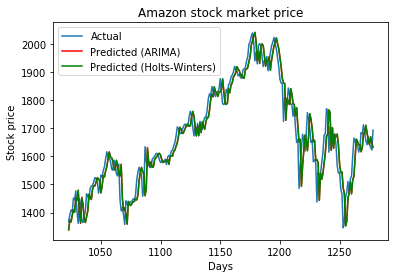

In [67]:
#ARIMA forecasting model - two days ahead stock market price prediction

q=2 #MA model order
p=2   #AR model order

# Train-test data split
n_train=int(0.8*len(Open_prices))
n_end=len(Open_prices)+1
Open_prices_train=Open_prices.iloc[1:n_train]
Open_prices_test=Open_prices.iloc[n_train:n_end]


# ARIMA vs Holts-Winters model performance - predicting two days' ahead stock prices
history = [x for x in Open_prices_train]
history.pop() # deleting history's last data point as this is not needed to obtain two days ahead prediction
predictions = list()
predictions_Holts=list()
    
#ARIMA Model (obtaining first prediction using only history data)
history_rolling=history
model_1 = ARIMA(history_rolling, order=(p,1,q))  
model_fit_1 = model_1.fit()                
output_1 = model_fit_1.forecast()           
yhat_1= output_1[0]
history_rolling.append(yhat_1)      # add one day's ahead prediction to history data in order to predict second day's
model_2 = ARIMA(history_rolling, order=(p,1,q))  
model_fit_2 = model_2.fit()                
output_2 = model_fit_2.forecast() 
yhat_2= output_2[0]
predictions.append(yhat_2)
print('ARIMA: predicted=%f, expected=%f' % (yhat_2, obs))
history_rolling=[]


#Holts-Winters Model (obtaining first prediction using only history data)
history_rolling_Holts=history
model_holts_1 = SimpleExpSmoothing(history_rolling_Holts).fit()  #Holts winters model
output_1_Holts =  model_holts_1.forecast()           
yhat_1_Holts= output_1_Holts[0]
history_rolling_Holts.append(yhat_1_Holts)    # add one day's ahead prediction to history data in order to predict second day's
model_holts_2 = SimpleExpSmoothing(history_rolling_Holts).fit()  #Holts winters model
output_2_Holts = model_holts_2.forecast() 
yhat_2_Holts= output_2_Holts[0]
predictions_Holts.append(yhat_2_Holts)
print('Holts-Winters: predicted=%f, expected=%f' % (yhat_2_Holts, obs))
history_rolling_Holts=[]


# redefining history so that it contains all training data
history = [x for x in Open_prices_train]


# Rolling forecasting using ARIMA and Holts-Winters (Two days ahead prices)
for t in range(n_train,len(Open_prices)):
    
    #ARIMA Model
    history_rolling=history
    model_1 = ARIMA(history_rolling, order=(p,1,q))  
    model_fit_1 = model_1.fit()                
    output_1 = model_fit_1.forecast()           
    yhat_1= output_1[0]
    history_rolling.append(yhat_1)
    model_2 = ARIMA(history_rolling, order=(p,1,q))  
    model_fit_2 = model_2.fit()                
    output_2 = model_fit_2.forecast() 
    yhat_2= output_2[0]
    predictions.append(yhat_2)
    history_rolling=[]  
    print('ARIMA: predicted=%f, expected=%f' % (yhat_2, obs))
    
   # Holts-Winters Triple Exponential Smoothing
   # model_holts = ExponentialSmoothing(history_holts, trend="add", seasonal="add",  seasonal_periods=260).fit()  #Holts winters model
   
   # Holts-Winters Simple Exponential Smoothing Model
    history_rolling_Holts=history
    model_holts_1 = SimpleExpSmoothing(history_rolling_Holts).fit()  #Holts winters model
    output_1_Holts =  model_holts_1.forecast()           
    yhat_1_Holts= output_1_Holts[0]
    history_rolling_Holts.append(yhat_1_Holts)
    model_holts_2 = SimpleExpSmoothing(history_rolling_Holts).fit()  #Holts winters model
    output_2_Holts = model_holts_2.forecast() 
    yhat_2_Holts= output_2_Holts[0]
    predictions_Holts.append(yhat_2_Holts)
    history_rolling_Holts=[]
    print('Holts-Winters: predicted=%f, expected=%f' % (yhat_2_Holts, obs))

    # Appending history using a new data point from test data in order to obtain new forecast in next iteration
    obs = Open_prices_test[t]
    history.append(obs)
    


# Evaluating performance of ARIMA model
predictions.pop()        #so that predictions with ARIMA equal number of points in test data
predictions_Holts.pop()  #so that predictions with Holts-Winters equal number of points in test data


#Computing sign accuracy of ARIMA and Holts-Winters models
i=1
returns_num_ARIMA=0
returns_num_Holts=0
returns_tot=0
while i<=len(predictions)-1:
    returns_predictions_ARIMA=predictions[i]-predictions[i-1]
    returns_predictions_Holts=predictions_Holts[i]-predictions_Holts[i-1]
    index_next=len(Open_prices)-len(predictions)+i
    index_previous=len(Open_prices)-len(predictions)+i-1
    returns_actual=Open_prices_test[index_next]-Open_prices_test[index_previous]
    if np.sign(returns_predictions_ARIMA)==np.sign(returns_actual):
        returns_num_ARIMA+=1
    if np.sign(returns_predictions_Holts)==np.sign(returns_actual):
        returns_num_Holts+=1
    returns_tot+=1
    i+=1
        
print('Sign accuracy (ARIMA) for two days ahead prices:', returns_num_ARIMA/returns_tot)
print('Sign accuracy (Holts-Winters) for two days ahead prices:', returns_num_Holts/returns_tot)


rmse = np.sqrt(mean_squared_error(Open_prices_test, predictions))
print('ARIMA: Test RMSE: %.3f' % rmse)

# Evaluating performance of Holts-Winters model
rmse = np.sqrt(mean_squared_error(Open_prices_test, predictions_Holts))
print('Holts-Winters: Test RMSE: %.3f' % rmse)

# Plot forecasts against actual test data prices (with ARIMA and Holts-Winters)
days_range=[day for day in range(n_train,len(Open_prices))]
line_up, =plt.plot(Open_prices_test, label='Actual')
line_down, =plt.plot(days_range, predictions, color='red', label='Predicted (ARIMA)')
line_mid, =plt.plot(days_range, predictions_Holts, color='green', label='Predicted (Holts-Winters)')
plt.legend(handles=[line_up, line_down, line_mid])
plt.title('Amazon stock market price')
plt.xlabel('Days')
plt.ylabel('Stock price') 
plt.show()